In [7]:
import os

# ------------------------------------------------------------
# Output
# ------------------------------------------------------------

BASE_DIR= r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
OUT_DIR = os.path.join(BASE_DIR,"v_results_3_output")
INP_DIR = os.path.join(BASE_DIR,"assets","calibration_outdoor_filtering")

FILES = {
    "Diffuse fraction filter":      os.path.join(INP_DIR,"7i.csv"),
    "Irradiance filter (EURAC)":    os.path.join(INP_DIR,"7e.csv"),
    # "Normal incidence filter":    os.path.join(INP_DIR,"7e.csv"),
    "Uncertainty filter":           os.path.join(INP_DIR,"7u.csv"),
    "Clear day filter":             os.path.join(INP_DIR,"7c.csv"),
}

X_COLUMN = "aoi_median"

Y_COLUMNS = {
    "Diffuse fraction filter":      "diffuse fraction filter",
    "Irradiance filter (EURAC)":    "irradiance filter",
    # "Normal incidence filter":    "irradiance filter",
    "Uncertainty filter":           "uncertainty filter",
    "Clear day filter":             "clear day filter",
}


— Series: 'Diffuse fraction filter'  |  File: C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\ground_based_solar_irradiance\assets\calibration_outdoor_filtering\7i.csv
✅ Using columns in '7i.csv' for 'Diffuse fraction filter': X='aoi_median', Y='diffuse fraction filter'
→ Parsed 'Diffuse fraction filter': 151 points (source Y had '%')
   AOI range: 23.41–68.04°,  CDF range: 0.66–100.00%

— Series: 'Irradiance filter (EURAC)'  |  File: C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\ground_based_solar_irradiance\assets\calibration_outdoor_filtering\7e.csv
✅ Using columns in '7e.csv' for 'Irradiance filter (EURAC)': X='aoi_median', Y='irradiance filter'
→ Parsed 'Irradiance filter (EURAC)': 45 points (source Y had '%')
   AOI range: 23.42–41.19°,  CDF range: 2.22–100.00%

— Series: 'Uncertainty filter'  |  File: C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\ground_based_solar_irradiance\assets\calibration_outdoor_filtering\7u.csv
✅

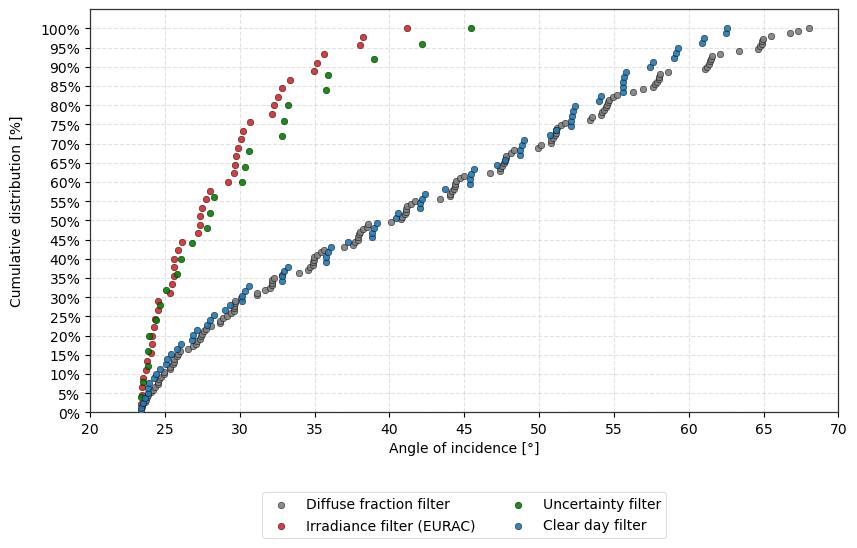

In [8]:
# -*- coding: utf-8 -*-
"""
Figure 3.3.2 — Cumulative distribution vs. Angle of incidence (scatter, CSV-only)

X (Excel K) : aoi_median
Y (Excel W) : series-specific headers
  - 7i.csv : 'diffuse fraction filter'         (Diffuse fraction filter)
  - 7e.csv : 'irradiance filter'               (Irradiance filter - EURAC)
  - 7u.csv : 'uncertainty filter'              (Uncertainty filter)
  - 7c.csv : 'clear day filter'                (Clear day filter)

The script:
- Enforces correct file↔series pairing and expected Y header.
- Parses numbers robustly (strips '%', handles comma decimals, whitespace).
- Automatically decides if Y is already % or fraction and scales to 0–100 %.
- Plots scatter with 5°/5% ticks and your requested colours.

No extra packages beyond numpy/pandas/matplotlib are required.
"""

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import textwrap
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FixedLocator

# --------------------------- Configuration ---------------------------


X_HEADER_EXPECTED = "aoi_median"
Y_HEADER_EXPECTED = {
    "Diffuse fraction filter":      "diffuse fraction filter",
    "Irradiance filter (EURAC)":    "irradiance filter",
    #"Normal incidence filter":    "irradiance filter",
    "Uncertainty filter":           "uncertainty filter",
    "Clear day filter":             "clear day filter",
}

# accepted header aliases (case/space-insensitive)
X_ALIASES = ["aoi_median", "aoi", "angle of incidence", "angle_of_incidence", "aoi [°]", "aoi [deg]"]

# plot look
COLORS = {
    "Diffuse fraction filter":      "#7f7f7f",  # GREY
    "Irradiance filter (EURAC)":    "#d62728", #f1c40f",  # YELLOW
    #"Normal incidence filter":    "#d62728", #f1c40f",  # YELLOW
    "Uncertainty filter":           "#008000", # "#d62728",  # RED
    "Clear day filter":             "#1f77b4",  # BLUE
}



MARKER, MSIZE, EDGE, EWIDTH, ALPHA = "o", 22, "black", 0.35, 0.9

OUT_DIR, OUT_NAME = "outputs", "Figure_3_3_2_scatter"
os.makedirs(OUT_DIR, exist_ok=True)

plt.rcParams.update({
    "axes.edgecolor": "#333",
    "axes.linewidth": 0.9,
    "grid.color": "#bdbdbd",
    "grid.linestyle": "--",
    "grid.alpha": 0.45,
    "axes.grid": True,
    "font.size": 10,
})

def wrap_text(text: str, width: int = 28) -> str:
    if not text: return text
    return "\n".join(textwrap.wrap(text, width=width, break_long_words=False, break_on_hyphens=False))

# --------------------------- Helpers ---------------------------
def _norm(name: str) -> str:
    """lower + strip non-alphanumerics for header matching"""
    return re.sub(r"[^a-z0-9]", "", str(name).strip().lower()) if name is not None else ""

def _find_header(df_cols, wanted_first, aliases):
    """Return actual column name matching wanted_first or any alias (case/space-insensitive)."""
    norm_map = {_norm(c): c for c in df_cols}
    # try exact expected first
    wf = _norm(wanted_first) if wanted_first else None
    if wf and wf in norm_map:
        return norm_map[wf]
    # try aliases
    for a in aliases:
        na = _norm(a)
        if na in norm_map:
            return norm_map[na]
    return None

def _parse_numeric_series(raw: pd.Series) -> tuple[pd.Series, bool]:
    """
    Parse a series that may contain:
      - percent strings like '2.22%' or '2,22 %'
      - comma or dot decimals
      - stray spaces / thin spaces
    Returns (numeric_series, is_percent_in_source)
    """
    # work on strings
    s_str = raw.astype(str).str.strip()

    # detect if any value has a '%' → then we treat as percentages
    has_pct = s_str.str.contains(r"%", regex=True, na=False).any()

    # unify decimal mark: replace comma with dot (but keep digits/decimal only)
    # remove %, spaces (including \u00A0, \u2009), thousands separators
    s_clean = (
        s_str.str.replace("\u00A0", "", regex=False)    # no‑break space
             .str.replace("\u2009", "", regex=False)    # thin space
             .str.replace(" ", "", regex=False)
             .str.replace(",", ".", regex=False)
             .str.replace("%", "", regex=False)
    )

    # finally parse
    s_num = pd.to_numeric(s_clean, errors="coerce")

    return s_num, has_pct

def read_series(csv_path: str, series_label: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Read X (AOI) and Y (CDF) for a given series:
      - enforce correct file↔series pairing by checking expected Y header exists
      - robustly parse X & Y numerics (incl. % strings and comma decimals)
      - convert Y to % if needed
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Missing CSV for '{series_label}': {csv_path}")

    df = pd.read_csv(csv_path, engine="python", sep=None)
    cols = list(df.columns)

    # find X header
    x_header = _find_header(cols, X_HEADER_EXPECTED, X_ALIASES)
    if x_header is None:
        raise KeyError(
            f"'{series_label}' → AOI column not found in {os.path.basename(csv_path)}.\n"
            f"  Wanted: {X_HEADER_EXPECTED} | Aliases: {X_ALIASES}\n"
            f"  Available: {cols}"
        )

    # find Y header: MUST match the series expected name in this file
    expected_y = Y_HEADER_EXPECTED[series_label]
    y_header = _find_header(cols, expected_y, [expected_y])  # no generic fallback here
    if y_header is None:
        # Stop here: this file is not the right one for this series
        raise KeyError(
            f"'{series_label}' → Expected Y header '{expected_y}' not found in {os.path.basename(csv_path)}.\n"
            f"  This strongly suggests the wrong file is mapped to this series.\n"
            f"  Available headers: {cols}\n"
            f"  → Please check FILES mapping: '{series_label}' must point to the CSV that contains '{expected_y}'."
        )

    # parse numerics with %/comma handling
    x_num, x_is_pct = _parse_numeric_series(df[x_header])
    y_num, y_is_pct = _parse_numeric_series(df[y_header])

    # AOI should never be percent—just coerce to numeric degrees
    # Y scaling: if source had '%', values are already percent; else assume fraction [0..1]
    if y_is_pct:
        y_pct = y_num  # already %
    else:
        y_pct = y_num * 100.0  # fraction → %

    # clean NaNs and non-finite
    m = x_num.notna() & y_pct.notna() & np.isfinite(x_num) & np.isfinite(y_pct)
    x = x_num[m].to_numpy(dtype=float)
    y = y_pct[m].to_numpy(dtype=float)

    # one more guard: clamp y to [0, 100] in case of outliers
    y = np.clip(y, 0.0, 100.0)

    # Logging
    print(f"✅ Using columns in '{os.path.basename(csv_path)}' for '{series_label}': X='{x_header}', Y='{y_header}'")
    print(f"→ Parsed '{series_label}': {x.size} points" + (f" (source Y had '%')" if y_is_pct else " (source Y was fraction)"))
    if x.size:
        print(f"   AOI range: {np.nanmin(x):.2f}–{np.nanmax(x):.2f}°,  CDF range: {np.nanmin(y):.2f}–{np.nanmax(y):.2f}%")

    return x, y

# --------------------------- Main ---------------------------
def main():
    fig, ax = plt.subplots(figsize=(8.6, 5.6))
    xs_all, ys_all = [], []

    for label, fname in FILES.items():
        csv_path = os.path.abspath(fname)
        print(f"\n— Series: '{label}'  |  File: {csv_path}")
        try:
            x, y = read_series(csv_path, label)
            if x.size == 0:
                print(f"⚠️ '{label}' has 0 valid points after parsing. Skipped.")
                continue
            xs_all.append(x); ys_all.append(y)
            ax.scatter(x, y, s=MSIZE, c=COLORS[label], marker=MARKER,
                       alpha=ALPHA, edgecolors=EDGE, linewidths=EWIDTH,
                       label=label, zorder=3)
        except Exception as e:
            # Stop immediately on mapping mistakes so the problem is obvious.
            raise

    # Labels
    ax.set_xlabel("Angle of incidence [°]")
    ax.set_ylabel(wrap_text("Cumulative distribution [%]", width=28), labelpad=12)

    # Axis ranges & ticks
    if xs_all:
        x_all = np.concatenate(xs_all)
        xmin, xmax = float(np.nanmin(x_all)), float(np.nanmax(x_all))
        xstart, xend = (np.floor(xmin / 5.0) * 5.0), (np.ceil(xmax / 5.0) * 5.0)
    else:
        print("⚠️ No valid X data across all series. Using default x-range (0°–90°).")
        xstart, xend = 0.0, 90.0

    ax.set_xlim(xstart, xend)
    ax.xaxis.set_major_locator(MultipleLocator(5))   # 5° ticks

    """ax.set_ylim(0.0, 100.0)
    ax.yaxis.set_major_locator(MultipleLocator(5))   # 5% ticks
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f%%"))"""

    
    # --- Y ticks every 5% from 0 to 100; extend ylim to 105 without showing it ---
    ax.set_ylim(0.0, 105.0)
    # Only show ticks up to 100 (no tick at 105)
    ax.yaxis.set_major_locator(FixedLocator(np.arange(0, 101, 5)))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f%%"))


    # Grid
    ax.grid(True, axis="both", which="major")
    ax.grid(False, axis="both", which="minor")

    # Legend & layout
    if xs_all:
        leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), ncol=2, frameon=True)
        leg.get_frame().set_linewidth(0.6)
    else:
        print("⚠️ No series plotted — legend suppressed.")

    fig.subplots_adjust(bottom=0.24, left=0.11, right=0.98, top=0.96)

    # Save
    out_png = os.path.join(OUT_DIR, f"{OUT_NAME}.png")
    out_svg = os.path.join(OUT_DIR, f"{OUT_NAME}.svg")
    fig.savefig(out_png, dpi=300)
    fig.savefig(out_svg)
    print(f"\nSaved: {out_png} and {out_svg}")

if __name__ == "__main__":
    main()